## Informed V-JEPA
We investigate how HNN and LNN and VJEPA can learn and represent the physics behind a pendulum.
Steps :
- through openai gym we generate synthetic pendulum images. Each image is labeled by the physical state theta, theta dot. This is the ground truth for the learning and evaluation of physics/
- use utility funvtions to compute and plot the energy and true phase space trajectories of the pendulum, enabling visual checks for consistency and energy conservation.
- train vjepa to predict future image patches, i.e. latent states too, and track loss curves for both jepa objective and physics informed loss we came up with.
- We check the relationship between learned latent representations and true physical variables. We use linear regression to map latents to physical variables with metrics such as R2 and MSE.
- We have plots that show how well the model conserves energy over time and how close its latent space aligns with the true dynamics, ie. try to provide insights how the network encapsulates the underlying physics.

In [1]:
# necessary imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import os
from PIL import Image, ImageDraw
import glob
import re

import gym

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
from utils.models import *
from utils.train_functions import *
from utils.helper_functions import *
from utils.datasets import *
from utils.loading_functions import *
from utils.evaluation_functions import *
from utils.evaluation_metrics import *

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
batch_size = 64
ds = PendulumDataset(num_episodes=40, episode_length=40,
                         img_size=64, seq_len=3)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Generating pendulum trajectories …


/global/homes/b/bleach/.conda/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40/40 [00:00<00:00, 204.95it/s]

Created 1520 windows (seq_len=3)


In [15]:
dl = DataLoader(
    PendulumDataset(
        episode_length = 300,
        seq_len        = 3,
        init_grid      = [ (th, om)
                           for th in np.linspace(-np.pi,  np.pi, 10)
                           for om in np.linspace(-5.0,    5.0,  10) ],
        random_action  = False),
    batch_size = 1024,
    shuffle    = False
)

Generating pendulum trajectories …


100%|██████████| 100/100 [00:01<00:00, 52.79it/s]

Created 29800 windows (seq_len=3)


In [16]:
if __name__ == "__main__":
    for mode in ["plain","hnn","lnn","hnn+lnn"]:
        cfg = TrainConfig.preset(mode)        # ← gets the right λ-weights
        cfg.suffix = "_dense_grid10x10"
        run_mode(cfg, dl)
    print("\nFinished all experiments; compare logs in ./results/results_<mode>_dense_grid10x10.npz")


### PLAIN | 10 epochs ###
ep01 jepa=0.801 lnn=0.000 hnn=0.000 sup=4.702 total=0.848
ep02 jepa=0.456 lnn=0.000 hnn=0.000 sup=4.314 total=0.499
ep03 jepa=0.310 lnn=0.000 hnn=0.000 sup=2.334 total=0.334
ep04 jepa=0.272 lnn=0.000 hnn=0.000 sup=1.334 total=0.285
ep05 jepa=0.255 lnn=0.000 hnn=0.000 sup=0.424 total=0.259
ep06 jepa=0.232 lnn=0.000 hnn=0.000 sup=0.185 total=0.234
ep07 jepa=0.226 lnn=0.000 hnn=0.000 sup=0.097 total=0.227
ep08 jepa=0.223 lnn=0.000 hnn=0.000 sup=0.057 total=0.223
ep09 jepa=0.220 lnn=0.000 hnn=0.000 sup=0.038 total=0.221
ep10 jepa=0.218 lnn=0.000 hnn=0.000 sup=0.029 total=0.218

### HNN | 10 epochs ###
ep01 jepa=0.789 lnn=0.000 hnn=0.038 sup=4.733 total=0.837
ep02 jepa=0.424 lnn=0.000 hnn=0.003 sup=4.370 total=0.468
ep03 jepa=0.294 lnn=0.000 hnn=0.011 sup=2.753 total=0.322
ep04 jepa=0.266 lnn=0.000 hnn=0.012 sup=1.704 total=0.284
ep05 jepa=0.254 lnn=0.000 hnn=0.005 sup=0.492 total=0.259
ep06 jepa=0.239 lnn=0.000 hnn=0.005 sup=0.167 total=0.240
ep07 jepa=0.227 lnn=

In [5]:
import os, re, glob, numpy as np
from dataclasses import asdict, is_dataclass

base_dir = "./results_numpy"
pattern  = "results_*_dense_grid10x10.npz"   # or "results_*.npz"

def load_results_npz(path):
    with np.load(path, allow_pickle=True) as npz:
        arrays = {k: npz[k] for k in npz.files}  # don't expect 'config' inside
    return normalise_keys(arrays)

logs = {}   # mode -> dict(arrays + 'config')

for path in glob.glob(os.path.join(base_dir, pattern)):
    # extract mode between 'results_' and '_dense.npz' (works for 'hnn+lnn' too)
    m = re.search(r"results_(.+?)_dense_grid10x10\.npz$", os.path.basename(path))
    if not m:
        print("skip", path); continue
    mode = m.group(1)

    arrays = load_results_npz(path)

    # Build/attach the right config for this mode
    cfg_mode = TrainConfig.preset(mode)     # or use your imported cfg if you want the same for all
    arrays["config"] = asdict(cfg_mode) if is_dataclass(cfg_mode) else cfg_mode

    logs[mode] = arrays
    print(f"loaded {mode:10} — epochs: {len(arrays['loss_total'])}")

loaded hnn+lnn    — epochs: 10
loaded hnn        — epochs: 10
loaded plain      — epochs: 10
loaded lnn        — epochs: 10


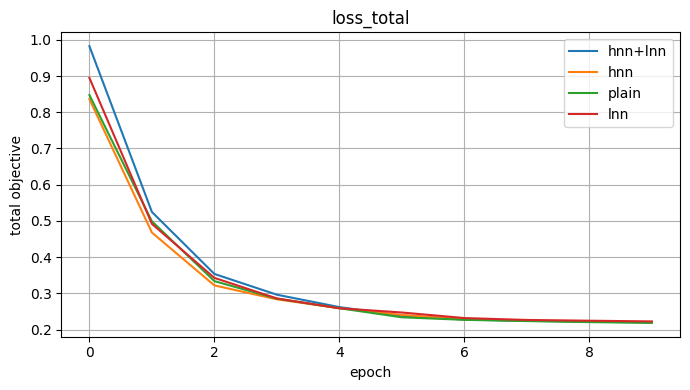

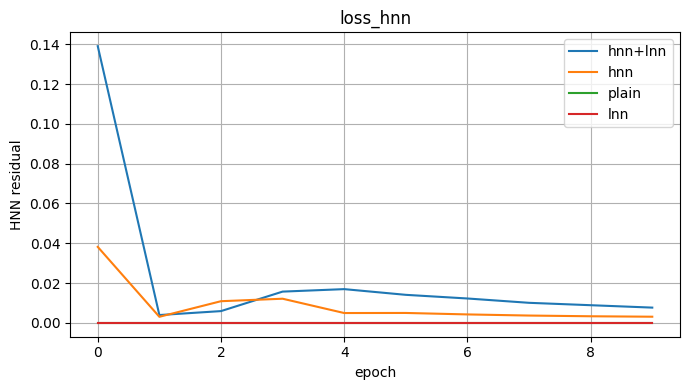

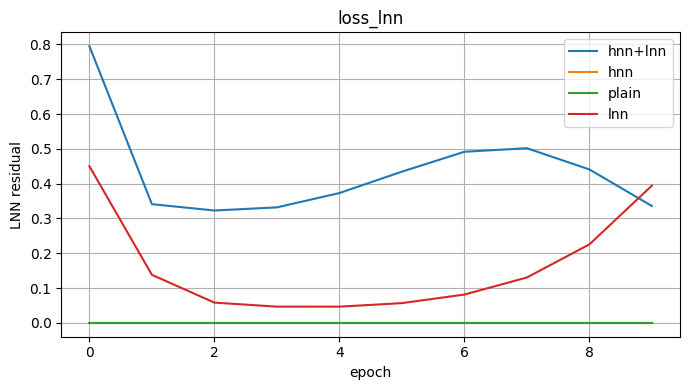

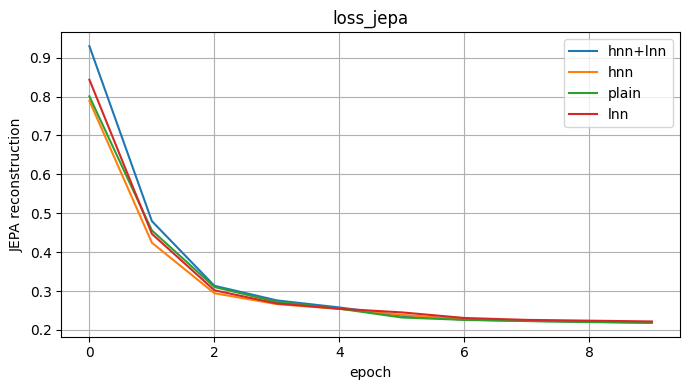

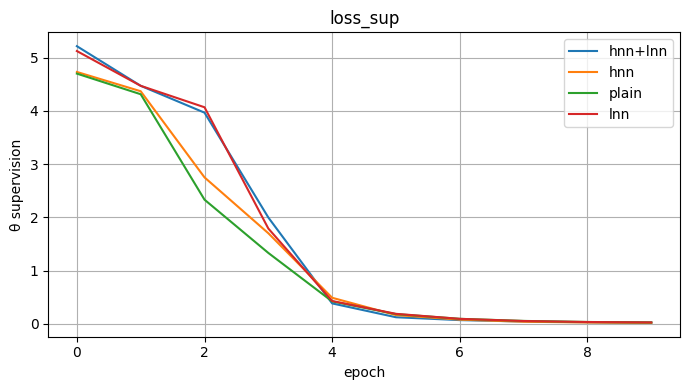

In [6]:
# ------------------------------------------------------------
#  Draw requested comparisons
# ------------------------------------------------------------

for key, label in metrics_to_plot:
    # plot only if *at least one* run recorded that key
    if any(key in rec for rec in logs.values()):
        plot_loss(key, logs, ylabel=label)          # plots every mode that has it
    else:
        print(f"[skip] no log contains '{key}'")

Generating pendulum trajectories …


100%|██████████| 30/30 [00:00<00:00, 44.16it/s]


Created 5940 windows (seq_len=3)


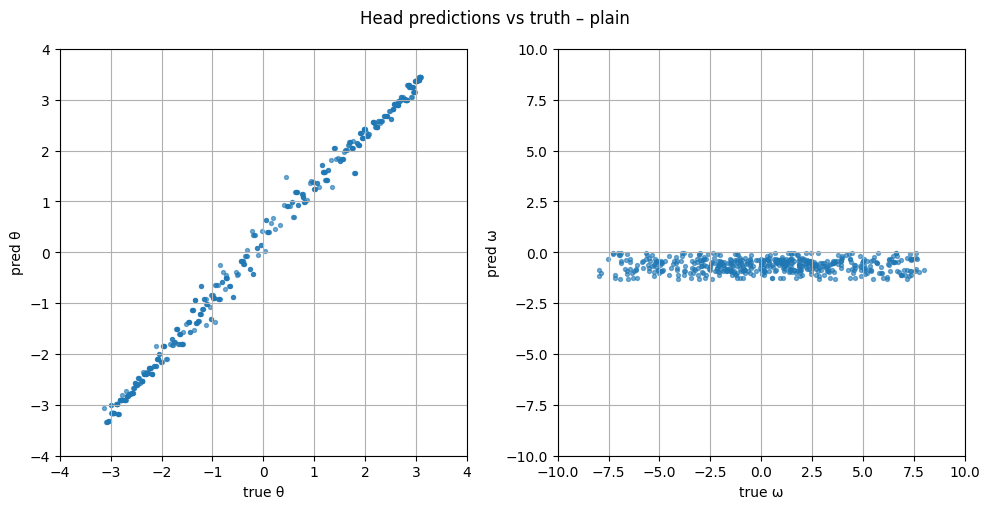

plain    → {'Δ_div': 0.1304, 'E_drift': 9.2472, 'Δ_rate': 0.0011, 'E_rate': 0.171, 'r2_theta': 0.9824, 'mse_theta': 0.0762, 'r2_omega': -0.0743, 'mse_omega': 16.0739} (saved → ./metrics/metrics_plain_dense_grid10x10.json)


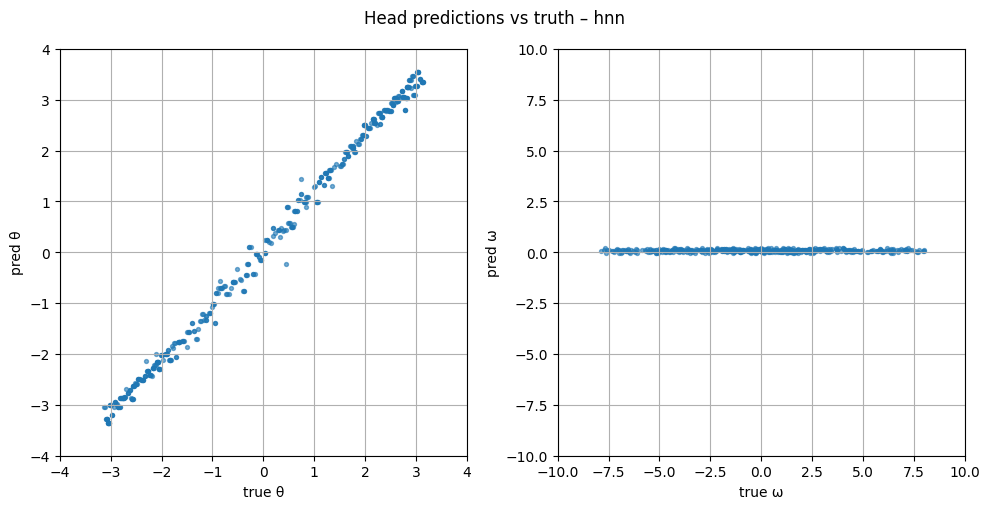

hnn      → {'Δ_div': 0.1229, 'E_drift': 2.3725, 'Δ_rate': 0.001, 'E_rate': 0.0403, 'r2_theta': 0.9836, 'mse_theta': 0.0694, 'r2_omega': -0.0012, 'mse_omega': 13.8882} (saved → ./metrics/metrics_hnn_dense_grid10x10.json)


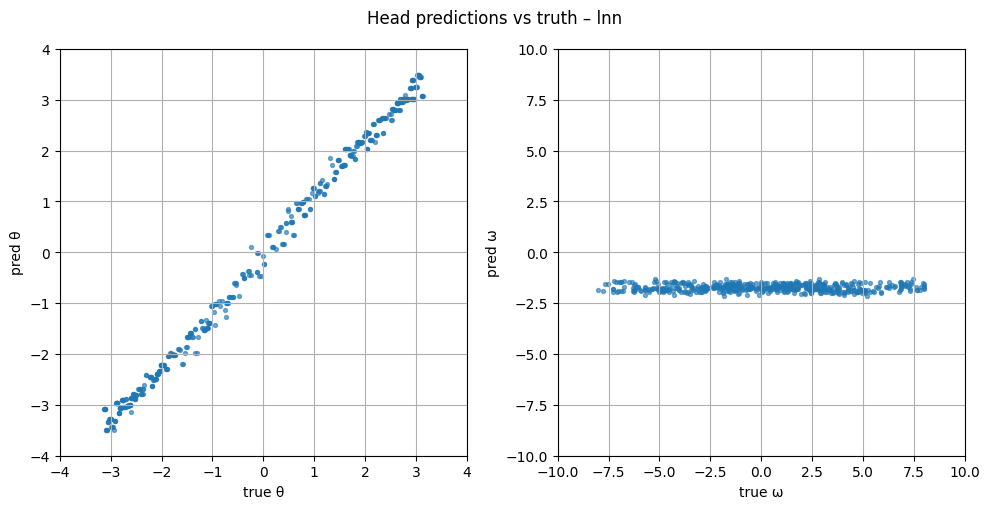

lnn      → {'Δ_div': 2.2575, 'E_drift': 32.1764, 'EL_res': 0.0118, 'Δ_rate': 0.0394, 'E_rate': 0.5462, 'EL_rate': -0.0014, 'r2_theta': 0.9835, 'mse_theta': 0.0733, 'r2_omega': -0.2549, 'mse_omega': 18.7763} (saved → ./metrics/metrics_lnn_dense_grid10x10.json)


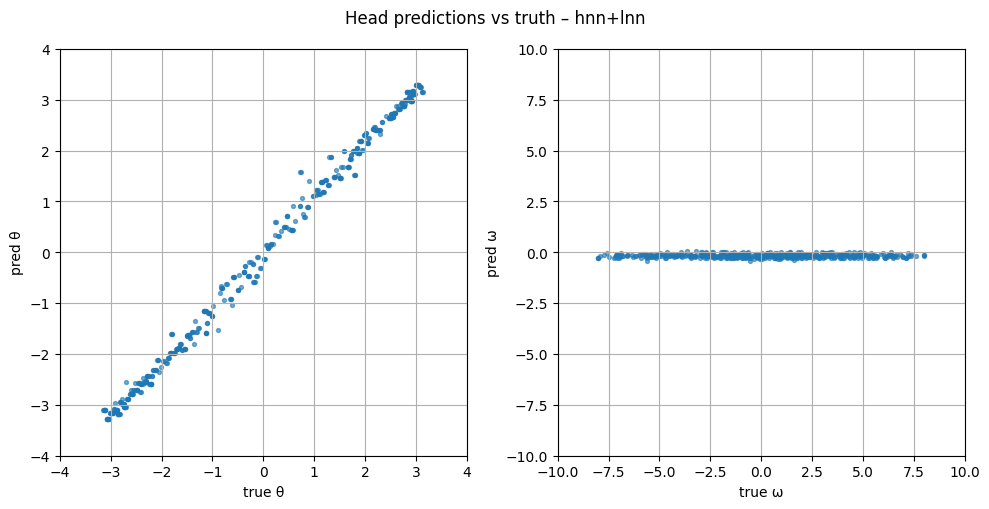

hnn+lnn  → {'Δ_div': 2.0033, 'E_drift': 4.141, 'EL_res': 0.0009, 'Δ_rate': 0.0347, 'E_rate': 0.0815, 'EL_rate': 0.0005, 'r2_theta': 0.9894, 'mse_theta': 0.0468, 'r2_omega': -0.013, 'mse_omega': 14.3654} (saved → ./metrics/metrics_hnn+lnn_dense_grid10x10.json)

✓ combined metrics saved → ./metrics/metrics_all_dense_grid10x10.json


In [10]:
# a PendulumDataset identical to the one you used for training
eval_ds = PendulumDataset(num_episodes=30, episode_length=200,
                         img_size=64, seq_len=3)
eval_cfg = EvalConfig()
eval_cfg.suffix = "_dense_grid10x10"

metrics = evaluate_all_modes(
    modes        = ["plain", "hnn", "lnn", "hnn+lnn"],
    dataset      = eval_ds,
    cfg          = eval_cfg,
    combine      = 'mean',   # example: 70 % HNN, 30 % LNN
    plot_scatter = True
)

In [4]:
# Testing the PendulumDataset
# Create a grid of initial conditions for the pendulum
# (theta, omega) pairs
grid = [(th, om)
        for th in np.linspace(-np.pi*2, np.pi*2, 10*2)
        for om in np.linspace(-5*2, 5*2, 10*2)]
ds = PendulumDataset(episode_length=300,
                     init_grid=grid,
                     random_action=False)

Generating pendulum trajectories …


/global/homes/b/bleach/.conda/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 400/400 [00:08<00:00, 44.80it/s]

Created 119200 windows (seq_len=3)


In [ ]:
eval_cfg = EvalConfig()
eval_cfg.out_dir = "./metrics_json_grid"
eval_cfg.suffix = "_dense_grid10x10"
eval_cfg.batch_size = 64

metrics = evaluate_all_modes(
    modes        = ["plain", "hnn", "lnn", "hnn+lnn"],
    dataset      = ds,
    cfg          = eval_cfg,
    combine      = 'mean',   # example: 70 % HNN, 30 % LNN
    plot_scatter = True
)

/pscratch/sd/b/bleach/physics_informed_machine_learning/utils/datasets.py:238: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.from_numpy(self.frames[i]).float()
                                                               

Generating pendulum trajectories …


100%|██████████| 25/25 [00:00<00:00, 45.24it/s]


Created 7450 windows (seq_len=3)


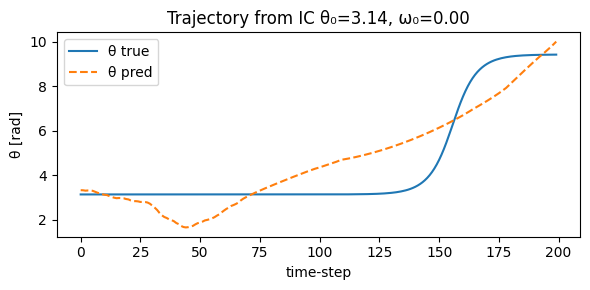

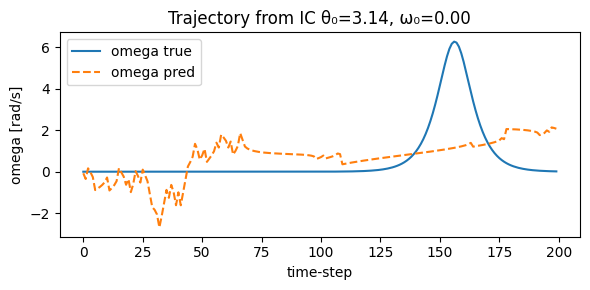

In [5]:
import numpy as np, torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from utils.datasets   import PendulumDataset
from utils.helper_functions   import rollout
from utils.loading_functions  import load_net

# ─── 1. build the evaluation loader (unchanged) ─────────────────────────
eval_loader = DataLoader(
    PendulumDataset(
        episode_length = 300,
        seq_len        = 3,
        init_grid      = [ (th, om)
                           for th in np.linspace(-np.pi,  np.pi, 5)
                           for om in np.linspace(-5.0,    5.0,  5) ],
        random_action  = False),
    batch_size = 64,
    shuffle    = False
)

# ─── 2. pick WHICH initial pair you want to visualise ───────────────────
target_ic = ( np.pi , 0.0 )      # 60° , 0 rad s⁻¹   (example)

# helper to locate the FIRST window that starts from that IC
def find_first_window(loader, ic, atol=1e-4):
    """Return (batch_idx, sample_idx) pointing at the first window
    whose very first frame matches `ic = (θ0, ω0)`."""
    θ0, ω0 = ic
    for b, (_, states) in enumerate(loader):
        θ_batch = states[:, 0, 0].numpy()
        ω_batch = states[:, 0, 1].numpy()
        for i, (θ, ω) in enumerate(zip(θ_batch, ω_batch)):
            if np.isclose(θ, θ0, atol=atol) and np.isclose(ω, ω0, atol=atol):
                return b, i
    raise ValueError("requested IC not present in loader")

batch_idx, sample_idx = find_first_window(eval_loader, target_ic)

# ─── 3. extract that single 3-frame window and feed it to rollout() ─────
seq, _ = next(iter(torch.utils.data.Subset(eval_loader.dataset,
                                           [batch_idx*64 + sample_idx])))
seq   = seq.unsqueeze(0)                               # (1,T,3,H,W)
dummy = torch.zeros(1, 2)                              # placeholder label
loader= DataLoader(TensorDataset(seq, dummy))

# ground-truth analytic -----------------------------------------------------------------
def true_rollout_single(ic, horizon, dt, g=9.81, l=1.0):
    θ0, ω0 = ic
    θ = torch.empty(horizon);  ω = torch.empty(horizon)
    θ[0], ω[0] = θ0, ω0
    for t in range(1, horizon):
        α      = -(g/l) * math.sin(θ[t-1])
        ω[t]   = ω[t-1] + α * dt
        θ[t]   = θ[t-1] + ω[t] * dt
    return θ.numpy(), ω.numpy()

θ_true, omega_true = true_rollout_single(target_ic, horizon=200, dt=0.05)

# network prediction --------------------------------------------------------------------
vjepa, head, hnn, lnn = load_net("hnn+lnn", suffix="_dense", model_dir="./models")
θ_pred, omega_pred, acc_pred = rollout(vjepa.eval(), head.eval(),
                       eval_loader = loader,
                       horizon     = 200,
                       dt          = 0.05,
                       hnn         = hnn,
                       lnn         = lnn,
                       combine     = "mean")

θ_pred = θ_pred.squeeze(0).numpy()
omega_pred = omega_pred.squeeze(0).numpy()
acc_pred = acc_pred.squeeze(0).numpy()

# ─── 4. plot the two curves ─────────────────────────────────────────────
plt.figure(figsize=(6,3))
plt.plot(θ_true, label="θ true")
plt.plot(θ_pred, "--", label="θ pred")
plt.title(f"Trajectory from IC θ₀={target_ic[0]:.2f}, ω₀={target_ic[1]:.2f}")
plt.xlabel("time-step"); plt.ylabel("θ [rad]")
plt.legend(); plt.tight_layout(); 

plt.figure(figsize=(6,3))
plt.plot(omega_true, label="omega true")
plt.plot(omega_pred, "--", label="omega pred")
plt.title(f"Trajectory from IC θ₀={target_ic[0]:.2f}, ω₀={target_ic[1]:.2f}")
plt.xlabel("time-step"); plt.ylabel("omega [rad/s]")
plt.legend(); plt.tight_layout(); 

plt.show()

Generating pendulum trajectories …


100%|██████████| 25/25 [00:00<00:00, 51.35it/s]


Created 7450 windows (seq_len=3)

=== Evaluating mode: plain (open-loop) ===


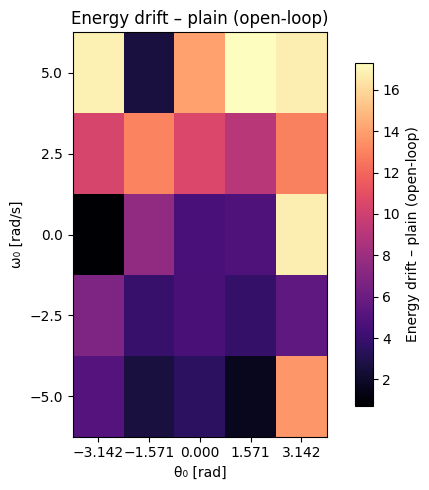

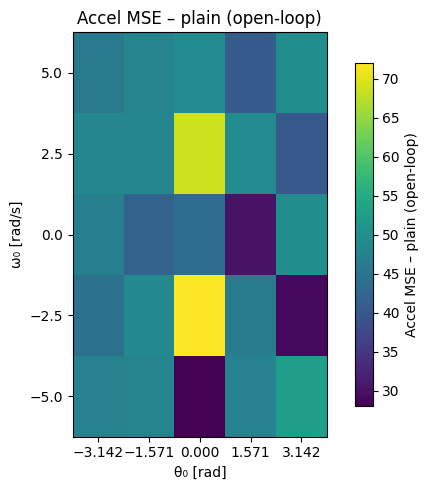


=== Evaluating mode: hnn (open-loop) ===


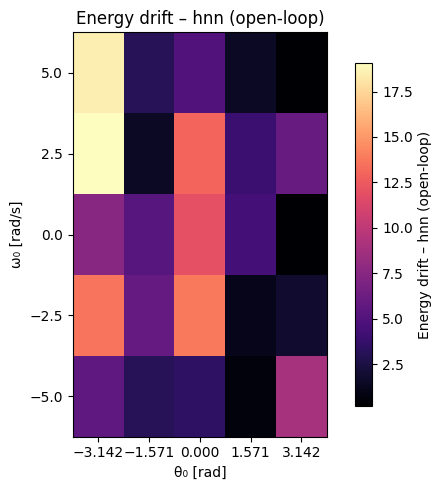

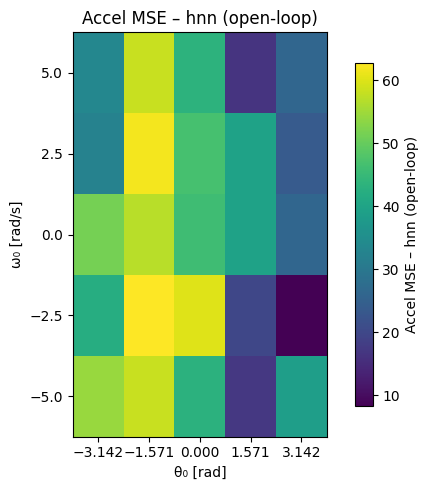


=== Evaluating mode: lnn (open-loop) ===


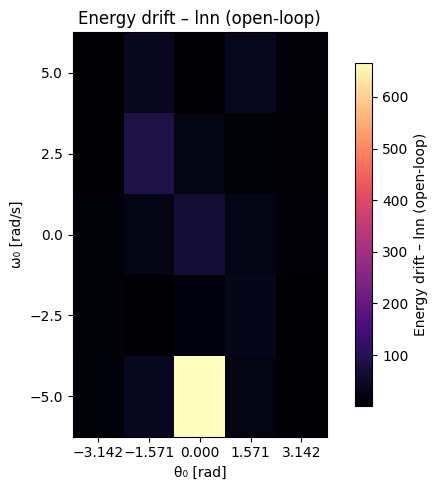

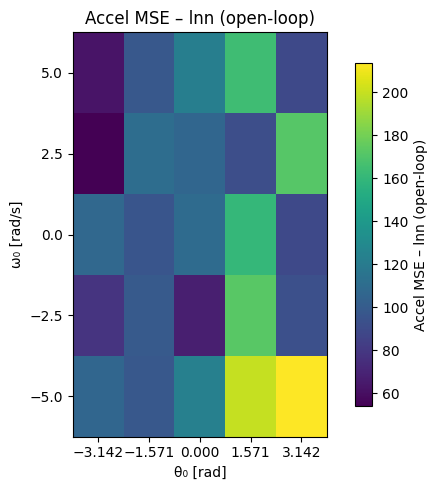


=== Evaluating mode: hnn+lnn (open-loop) ===


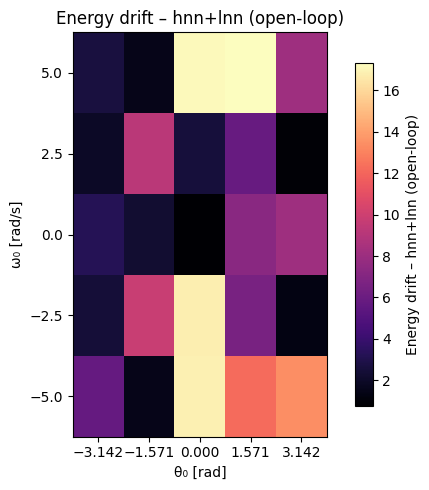

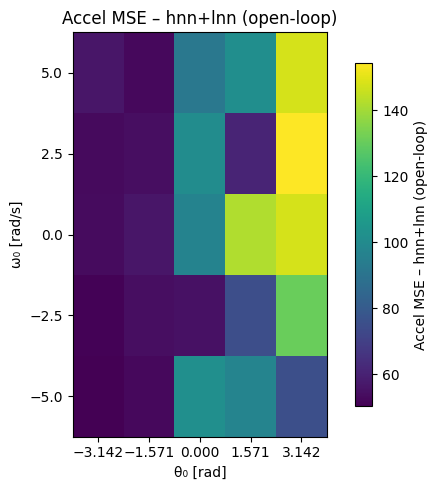

In [14]:
# ===============================================
# Grid-wide evaluation: per-IC metrics + heatmaps
# ===============================================
# Assumes your existing `rollout`, `PendulumDataset`, `load_net`, and the metric
# helpers you pasted (energy_drift, accel_mse, etc.) are available.
#
# What this does:
#   • Runs OPEN-LOOP rollouts for every IC in your eval grid.
#   • Computes per-IC metrics (energy drift, accel MSE).
#   • Stores them in 2D arrays shaped like (len(theta_grid), len(omega_grid)).
#   • Plots and saves heatmaps for each model (“plain”, “hnn”, “lnn”, “hnn+lnn”).
#
# Optional: CLOSED-LOOP evaluation (periodic re-init from frames) is included as a
#           switch. See `run_closed_loop` flag in `eval_model_over_grid`.
#
# NOTE on init: for OPEN-LOOP, initializing from the 3-frame context generally
# matches training and improves stability. If you want that, apply the *tiny*
# patch in rollout to support `init="mean3"`, as shown below in the comment.
# Until then, this script uses your current rollout (first-frame init).
# ===============================================

import os, math, json, numpy as np, torch, matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, Tuple, List
from torch.utils.data import DataLoader
from utils.datasets   import PendulumDataset
from utils.helper_functions   import rollout   # ← uses first frame by default
from utils.loading_functions  import load_net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 0) Build the eval DataLoader
# --------------------------
theta_grid = np.linspace(-np.pi,  np.pi, 5)
omega_grid = np.linspace(-5.0,    5.0,   5)
grid_ICs   = [ (th, om) for th in theta_grid for om in omega_grid ]

episode_length = 300
seq_len        = 3
H              = 200
DT             = 0.05

dataset = PendulumDataset(
    episode_length = episode_length,
    seq_len        = seq_len,
    init_grid      = grid_ICs,
    random_action  = False
)
eval_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# -----------------------------------------
# 1) (Optional) rollout init "mean3" patch
# -----------------------------------------
# If you want to initialize from all 3 frames (recommended for open-loop), add this
# tiny change inside your rollout():
#
#   def rollout(..., init: str = "first", ...):
#       ...
#       for seq, _ in eval_loader:
#           if init == "first":
#               imgs0 = seq[:, 0].to(device)
#               z0 = vjepa.context_encoder(vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
#           elif init == "mean3":
#               imgs_ctx = seq[:, :3].to(device)
#               z_list = []
#               for t in range(imgs_ctx.shape[1]):
#                   zt = vjepa.context_encoder(vjepa.patch_embed(imgs_ctx[:, t]) + vjepa.pos_embed).mean(1)
#                   z_list.append(zt)
#               z0 = torch.stack(z_list, 1).mean(1)
#           θ, ω = head(z0).split(1, dim=1); θ, ω = θ.squeeze(1), ω.squeeze(1)
#
# Then call rollout(..., init="mean3", ...). The rest of this script will work unchanged.

# -----------------------------------------
# 2) Per-IC metric helpers (vectorized)
# -----------------------------------------

def energy_drift_per_ic(theta: torch.Tensor, omega: torch.Tensor,
                        m: float=1.0, g: float=9.81, l: float=1.0) -> np.ndarray:
    """|E_T − E_0| per trajectory; returns (N,) numpy array."""
    E0 = 0.5 * m * l**2 * omega[:, 0]**2 + m * g * l * (1 - torch.cos(theta[:, 0]))
    Et = 0.5 * m * l**2 * omega[:, -1]**2 + m * g * l * (1 - torch.cos(theta[:, -1]))
    return (Et - E0).abs().cpu().numpy()

def accel_mse_per_ic(theta: torch.Tensor, alpha_pred: torch.Tensor,
                     g: float=9.81, l: float=1.0) -> np.ndarray:
    """MSE over time between predicted α and analytic α(θ) per trajectory; returns (N,)."""
    # Ignore the final step to match lengths
    alpha_true = -g / l * torch.sin(theta[:, :-1])
    se = (alpha_pred[:, :-1] - alpha_true)**2               # (N,T-1)
    return se.mean(dim=1).cpu().numpy()                     # (N,)

def reshape_to_grid(values: np.ndarray,
                    theta0: np.ndarray, omega0: np.ndarray,
                    theta_axis: np.ndarray, omega_axis: np.ndarray) -> np.ndarray:
    """
    Arrange a flat per-trajectory array into a (len(theta_axis), len(omega_axis)) grid
    by matching each trajectory's (θ0, ω0) to the closest bin.
    """
    Th = len(theta_axis); Om = len(omega_axis)
    grid = np.full((Th, Om), np.nan)
    # build index maps
    t_idx = {i: i for i in range(Th)}
    o_idx = {j: j for j in range(Om)}

    # nearest-bin matcher
    def nearest(arr, x):
        return int(np.argmin(np.abs(arr - x)))

    # fill – if multiple windows exist for same (θ0,ω0), take the first
    seen = set()
    for k, (th0, om0) in enumerate(zip(theta0, omega0)):
        i = nearest(theta_axis, th0)
        j = nearest(omega_axis, om0)
        if (i, j) in seen:
            continue
        grid[i, j] = values[k]
        seen.add((i, j))
    return grid

# ------------------------------------------------
# 3) Ground-truth integrator (for reference plots)
# ------------------------------------------------
def true_rollout_single(ic: Tuple[float,float], horizon: int, dt: float, g=9.81, l=1.0):
    θ0, ω0 = ic
    θ = np.empty(horizon, np.float64); ω = np.empty(horizon, np.float64)
    θ[0], ω[0] = θ0, ω0
    for t in range(1, horizon):
        α    = -(g/l) * math.sin(θ[t-1])
        ω[t] = ω[t-1] + α * dt
        θ[t] = θ[t-1] + ω[t] * dt
    return θ, ω

def collect_true_ics(eval_loader):
    th0, om0 = [], []
    for _, states in eval_loader:                 # states: (B, T, 2)
        th0.append(states[:, 0, 0].numpy())
        om0.append(states[:, 0, 1].numpy())
    return np.concatenate(th0), np.concatenate(om0)
    
# ------------------------------------------------
# 4) Evaluate one model over the whole IC grid
# ------------------------------------------------
def eval_model_over_grid(
    mode: str,
    *,
    model_dir: str = "./models",
    suffix    : str = "_dense",
    combine   : str | Tuple[str, float] | None = "mean",
    dt        : float = DT,
    horizon   : int = H,
    use_mean3_init: bool = False,
    run_closed_loop: bool = False,
    reinit_every: int = 10      # only for closed-loop
) -> Dict[str, np.ndarray]:
    """
    Runs rollout over the WHOLE eval_loader (all ICs), computes per-IC metrics,
    and returns dicts with 2D heatmap arrays.
    """
    # ---- load nets
    vjepa, head, hnn, lnn = load_net(mode, suffix=suffix, model_dir=model_dir)
    vjepa.eval(); head.eval()
    if hnn: hnn.eval()
    if lnn: lnn.eval()

    # ---- do a single pass rollout (open-loop or closed-loop)
    if not run_closed_loop:
        # OPEN-LOOP (uses your rollout as-is; pass init="mean3" if you patched it)
        θ_pred, ω_pred, α_pred = rollout(
            vjepa, head,
            eval_loader = eval_loader,
            horizon     = horizon,
            dt          = dt,
            hnn         = hnn,
            lnn         = lnn,
            combine     = combine if (hnn is not None and lnn is not None) else None,
            # init="mean3" if you added that tiny patch
        )
    else:
        # CLOSED-LOOP: periodically re-encode from frames to reset (θ,ω).
        # Minimal implementation: re-run rollout in chunks of length `reinit_every`,
        # re-initializing each chunk from the current observed frame(s).
        Θ_list, Ω_list, Α_list = [], [], []
        # Iterate once over the eval_loader to get sequences
        for seq, _ in eval_loader:
            seq = seq.to(device)  # (B,T,3,H,W)
            B = seq.size(0)
            # init from first chunk
            chunk_steps = math.ceil(horizon / reinit_every)
            θ_chunks, ω_chunks, α_chunks = [], [], []
            θ_cur = torch.empty((B,0), device=device); ω_cur = torch.empty((B,0), device=device)
            α_cur = torch.empty((B,0), device=device)

            t_rem = horizon
            frame_ptr = 0
            while t_rem > 0:
                # re-init from current observed frame(s)
                imgs0 = seq[:, min(frame_ptr, seq.size(1)-1)]
                z0 = vjepa.context_encoder(vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
                θ0, ω0 = head(z0).split(1, dim=1); θ0, ω0 = θ0.squeeze(1), ω0.squeeze(1)

                # roll short open-loop chunk
                Tchunk = min(reinit_every, t_rem)
                θc = [θ0]; ωc = [ω0]; αc = []
                for _ in range(Tchunk-1):
                    q, v = θc[-1].detach(), ωc[-1].detach()
                    with torch.set_grad_enabled(True):
                        if (hnn is not None) and (lnn is not None) and (combine == "mean"):
                            # simple mean fusion; expand if needed
                            from utils.helper_functions import lnn_accel
                            α_h = hnn.time_derivative(torch.stack([q.reshape(-1), v.reshape(-1)], 1).requires_grad_(True))
                            α_h = α_h[:,1] if (α_h.ndim==2 and α_h.size(-1)>=2) else α_h.reshape(-1)
                            α_l = lnn_accel(lnn, q, v, dt=dt)
                            α   = 0.5*(α_h + α_l)
                        elif hnn is not None:
                            α_h = hnn.time_derivative(torch.stack([q.reshape(-1), v.reshape(-1)], 1).requires_grad_(True))
                            α   = α_h[:,1] if (α_h.ndim==2 and α_h.size(-1)>=2) else α_h.reshape(-1)
                        elif lnn is not None:
                            from utils.helper_functions import lnn_accel
                            α = lnn_accel(lnn, q, v, dt=dt)
                        else:
                            α = torch.zeros_like(v)
                    θc.append(q + v*dt)
                    ωc.append(v + α*dt)
                    αc.append(α)

                # assemble chunk
                αc = [torch.zeros_like(αc[0])] + αc if len(αc)>0 else [torch.zeros_like(ω0)]
                θc = torch.stack(θc, 1); ωc = torch.stack(ωc, 1); αc = torch.stack(αc, 1)

                θ_cur = torch.cat([θ_cur, θc], 1)
                ω_cur = torch.cat([ω_cur, ωc], 1)
                α_cur = torch.cat([α_cur, αc], 1)

                t_rem     -= Tchunk
                frame_ptr += Tchunk

            Θ_list.append(θ_cur.detach().cpu())
            Ω_list.append(ω_cur.detach().cpu())
            Α_list.append(α_cur.detach().cpu())

        θ_pred = torch.cat(Θ_list, 0)
        ω_pred = torch.cat(Ω_list, 0)
        α_pred = torch.cat(Α_list, 0)

    # ---- extract initial conditions actually used
    # ---- get TRUE ICs (not predicted)
    true_theta0, true_omega0 = collect_true_ics(eval_loader)
    
    # ---- compute per-IC metrics
    e_drift = energy_drift_per_ic(θ_pred, ω_pred, m=1.0, g=9.81, l=1.0)
    a_mse   = accel_mse_per_ic(θ_pred, α_pred, g=9.81, l=1.0)
    
    # ---- bin by true ICs → guarantees 25 filled bins
    e_grid = reshape_to_grid(e_drift, true_theta0, true_omega0, theta_grid, omega_grid)
    a_grid = reshape_to_grid(a_mse,   true_theta0, true_omega0, theta_grid, omega_grid)

    return {
        "theta0": true_theta0,
        "omega0": true_omega0,
        "E_drift_grid": e_grid,
        "AccelMSE_grid": a_grid,
    }

# ------------------------------------------------
# 5) Run for multiple modes and plot heatmaps
# ------------------------------------------------
def _edges_from_centers(x: np.ndarray) -> np.ndarray:
    """Compute bin edges from 1D centers (handles nonuniform spacing)."""
    mids = 0.5*(x[:-1] + x[1:])
    first_edge = x[0] - (mids[0] - x[0])
    last_edge  = x[-1] + (x[-1] - mids[-1])
    return np.concatenate([[first_edge], mids, [last_edge]])

def plot_heatmap(grid: np.ndarray, title: str, fname: str,
                 theta_axis=theta_grid, omega_axis=omega_grid, cmap="magma"):
    # grid shape: (len(theta_axis), len(omega_axis))
    # build 2D cell edges so each value occupies one square
    θe = _edges_from_centers(theta_axis)
    ωe = _edges_from_centers(omega_axis)

    plt.figure(figsize=(6, 5))
    # Note: pcolormesh expects Z shaped (ny, nx) → transpose if needed
    pc = plt.pcolormesh(θe, ωe, grid.T, cmap=cmap, shading="flat")
    plt.gca().set_aspect("equal", adjustable="box")  # optional: square cells
    plt.colorbar(pc, shrink=0.85, label=title)

    # put ticks exactly at your IC centers
    plt.xticks(theta_axis, rotation=0)
    plt.yticks(omega_axis)
    plt.xlabel("θ₀ [rad]"); plt.ylabel("ω₀ [rad/s]")
    plt.title(title); plt.tight_layout()

    os.makedirs("heatmaps", exist_ok=True)
    plt.savefig(os.path.join("heatmaps", fname), dpi=160)
    plt.show()



modes = ["plain", "hnn", "lnn", "hnn+lnn"]

results: Dict[str, Dict[str, np.ndarray]] = {}
for mode in modes:
    print(f"\n=== Evaluating mode: {mode} (open-loop) ===")
    results[mode] = eval_model_over_grid(
        mode,
        model_dir="./models",
        suffix="_dense",
        combine="mean",           # used only when both HNN and LNN exist
        dt=DT, horizon=H,
        use_mean3_init=False,     # set True if you applied the rollout init patch
        run_closed_loop=False
    )
    
    plot_heatmap(results[mode]["E_drift_grid"],
                 title=f"Energy drift – {mode} (open-loop)",
                 fname=f"energy_drift_{mode}_open.png")
    plot_heatmap(results[mode]["AccelMSE_grid"],
                 title=f"Accel MSE – {mode} (open-loop)",
                 fname=f"accel_mse_{mode}_open.png",
                 cmap="viridis")

# (Optional) CLOSED-LOOP pass (uncomment if you want to compare)
# for mode in modes:
#     print(f"\n=== Evaluating mode: {mode} (closed-loop, reinit/10) ===")
#     res_cl = eval_model_over_grid(
#         mode,
#         model_dir="./models",
#         suffix="_dense",
#         combine="mean",
#         dt=DT, horizon=H,
#         run_closed_loop=True,
#         reinit_every=10
#     )
#     plot_heatmap(res_cl["E_drift_grid"],
#                  title=f"Energy drift – {mode} (closed-loop /10)",
#                  fname=f"energy_drift_{mode}_closed.png")
#     plot_heatmap(res_cl["AccelMSE_grid"],
#                  title=f"Accel MSE – {mode} (closed-loop /10)",
#                  fname=f"accel_mse_{mode}_closed.png")

/tmp/ipykernel_1349378/1437899389.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


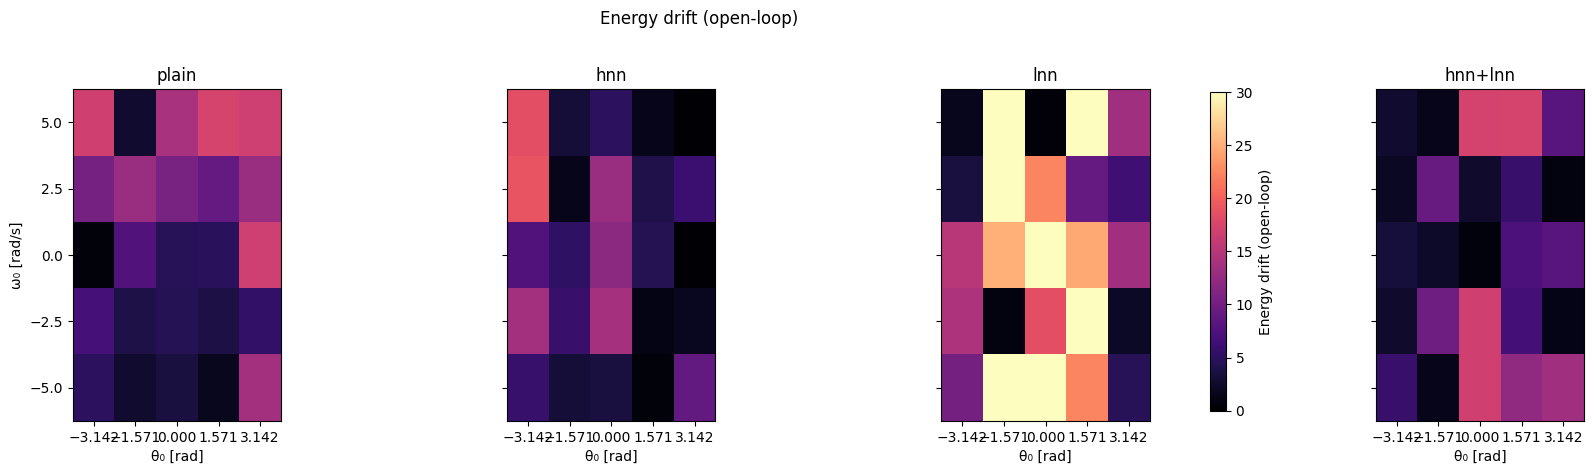

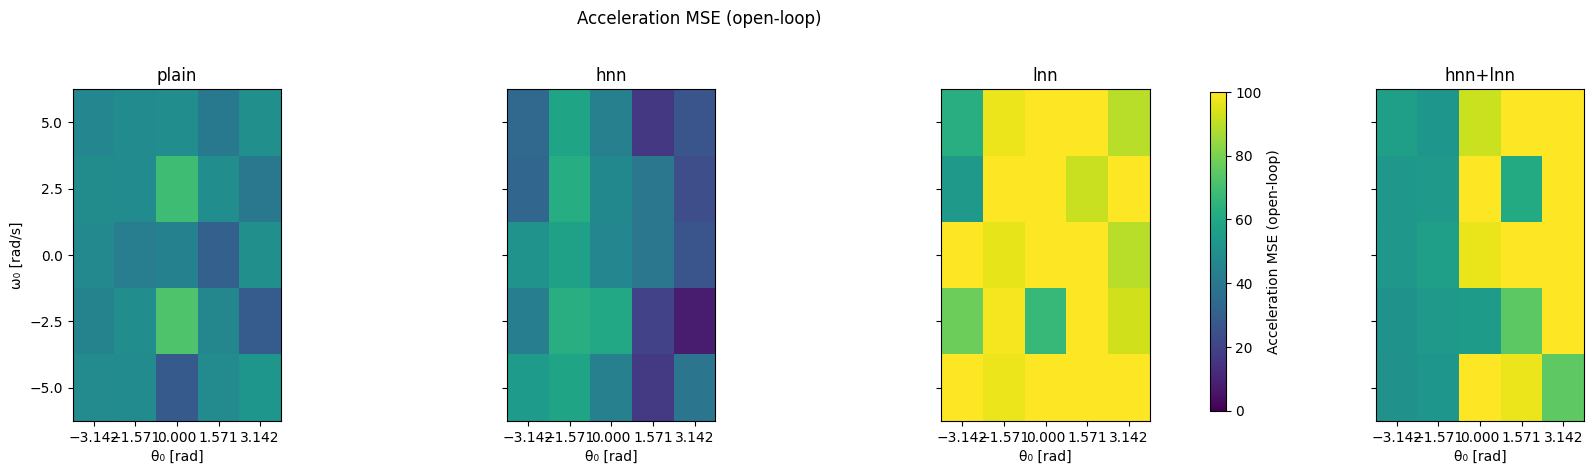

In [20]:
def plot_metric_row(
    results: dict,
    modes: list[str],
    metric_key: str,             # e.g. "E_drift_grid" or "AccelMSE_grid"
    *,
    theta_axis: np.ndarray,
    omega_axis: np.ndarray,
    title: str,
    cmap: str = "magma",
    vmin: float | None = None,
    vmax: float | None = None,
    clip_percentile: tuple[float,float] | None = None,
    savepath: str | None = None
):
    """
    Draws a row of heatmaps (one per mode) with a SHARED colorbar.
    """
    grids = [results[m][metric_key] for m in modes]
    stack = np.stack(grids, axis=0)

    # global limits if not provided
    if clip_percentile is not None:
        lo, hi = np.nanpercentile(stack, list(clip_percentile))
        vmin = lo if vmin is None else vmin
        vmax = hi if vmax is None else vmax
    else:
        vmin = np.nanmin(stack) if vmin is None else vmin
        vmax = np.nanmax(stack) if vmax is None else vmax

    θe = _edges_from_centers(theta_axis)
    ωe = _edges_from_centers(omega_axis)

    n = len(modes)
    fig, axes = plt.subplots(1, n, figsize=(4.2*n+1.2, 4.6), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    mappables = []
    for ax, mode, grid in zip(axes, modes, grids):
        pc = ax.pcolormesh(θe, ωe, grid.T, cmap=cmap, shading="flat", vmin=vmin, vmax=vmax)
        mappables.append(pc)
        ax.set_title(mode)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xticks(theta_axis); ax.set_yticks(omega_axis)
        ax.set_xlabel("θ₀ [rad]")
    axes[0].set_ylabel("ω₀ [rad/s]")

    # One shared colorbar for the row
    cbar = fig.colorbar(mappables[0], ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label(title)

    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    plt.show()



present_modes = [m for m in ["plain", "hnn", "lnn", "hnn+lnn"] if m in results]

E_vmin, E_vmax = 0, 30
A_vmin, A_vmax = 0, 100

# Energy drift row (shared colorbar)
plot_metric_row(
    results, present_modes, "E_drift_grid",
    theta_axis=theta_grid, omega_axis=omega_grid,
    title="Energy drift (open-loop)",
    cmap="magma",
    vmin=E_vmin, vmax=E_vmax,
    savepath="heatmaps/row_energy_drift_open.png"
)

# Accel MSE row (shared colorbar)
plot_metric_row(
    results, present_modes, "AccelMSE_grid",
    theta_axis=theta_grid, omega_axis=omega_grid,
    title="Acceleration MSE (open-loop)",
    cmap="viridis",
    vmin=A_vmin, vmax=A_vmax,
    savepath="heatmaps/row_accel_mse_open.png"
)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

def _finite_positive(vals: np.ndarray) -> np.ndarray:
    vals = vals[np.isfinite(vals)]
    return vals[vals > 0]

def _edges_from_centers(x: np.ndarray) -> np.ndarray:
    mids = 0.5*(x[:-1] + x[1:])
    first_edge = x[0] - (mids[0] - x[0])
    last_edge  = x[-1] + (x[-1] - mids[-1])
    return np.concatenate([[first_edge], mids, [last_edge]])

def plot_metric_row(
    results: dict,
    modes: list[str],
    metric_key: str,             # e.g. "E_drift_grid" or "AccelMSE_grid"
    *,
    theta_axis: np.ndarray,
    omega_axis: np.ndarray,
    title: str,
    cmap: str = "magma",
    scale: str = "log",          # "log" or "linear"
    vmin: float | None = None,
    vmax: float | None = None,
    clip_percentile: tuple[float,float] | None = None,  # e.g. (1, 99)
    eps: float | None = None,    # small positive floor when using log scale
    savepath: str | None = None
):
    """
    Draws a row of heatmaps (one per mode) with a SHARED colorbar.
    Robust auto-scaling + optional log scale.
    """
    grids = [np.array(results[m][metric_key], copy=True) for m in modes]
    stack = np.stack(grids, axis=0)

    # Handle zeros/negatives for log scale by flooring to small positive eps (masked preferred).
    if scale == "log":
        # find robust epsilon if not provided
        pos_vals = _finite_positive(stack.ravel())
        if pos_vals.size == 0:
            # no positive finite data; fall back gracefully
            eps_eff = 1e-12
        else:
            # set eps one order of magnitude below the smallest positive value
            eps_eff = 10**(np.floor(np.log10(pos_vals.min())) - 1) if eps is None else eps
        # replace non-positive or non-finite with eps (or mask them)
        for k in range(len(grids)):
            g = grids[k]
            bad = ~np.isfinite(g) | (g <= 0)
            if bad.any():
                g = g.copy()
                g[bad] = eps_eff
                grids[k] = g
        stack = np.stack(grids, axis=0)

    # Compute global limits if not provided
    if scale == "log":
        vals = _finite_positive(stack.ravel())
        if vals.size == 0:
            # fallback
            auto_vmin, auto_vmax = 1e-12, 1.0
        else:
            if clip_percentile is not None:
                lo, hi = np.percentile(vals, list(clip_percentile))
                auto_vmin, auto_vmax = max(lo, np.finfo(float).tiny), hi
            else:
                auto_vmin, auto_vmax = vals.min(), vals.max()
        vmin = auto_vmin if vmin is None else vmin
        vmax = auto_vmax if vmax is None else vmax
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        vals = stack.ravel()
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            auto_vmin, auto_vmax = 0.0, 1.0
        else:
            if clip_percentile is not None:
                lo, hi = np.percentile(vals, list(clip_percentile))
                auto_vmin, auto_vmax = lo, hi
            else:
                auto_vmin, auto_vmax = vals.min(), vals.max()
        vmin = auto_vmin if vmin is None else vmin
        vmax = auto_vmax if vmax is None else vmax
        norm = Normalize(vmin=vmin, vmax=vmax)

    θe = _edges_from_centers(theta_axis)
    ωe = _edges_from_centers(omega_axis)

    n = len(modes)
    fig, axes = plt.subplots(1, n, figsize=(4.2*n+1.2, 4.6), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    mappables = []
    for ax, mode, grid in zip(axes, modes, grids):
        pc = ax.pcolormesh(θe, ωe, grid.T, cmap=cmap, shading="flat", norm=norm)
        mappables.append(pc)
        ax.set_title(mode)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xticks(theta_axis); ax.set_yticks(omega_axis)
        ax.set_xlabel("θ₀ [rad]")
    axes[0].set_ylabel("ω₀ [rad/s]")

    cbar = fig.colorbar(mappables[0], ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label(title)

    fig.suptitle(f"{title}  ({scale} scale)", y=1.02, fontsize=12)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_1349378/3995676379.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


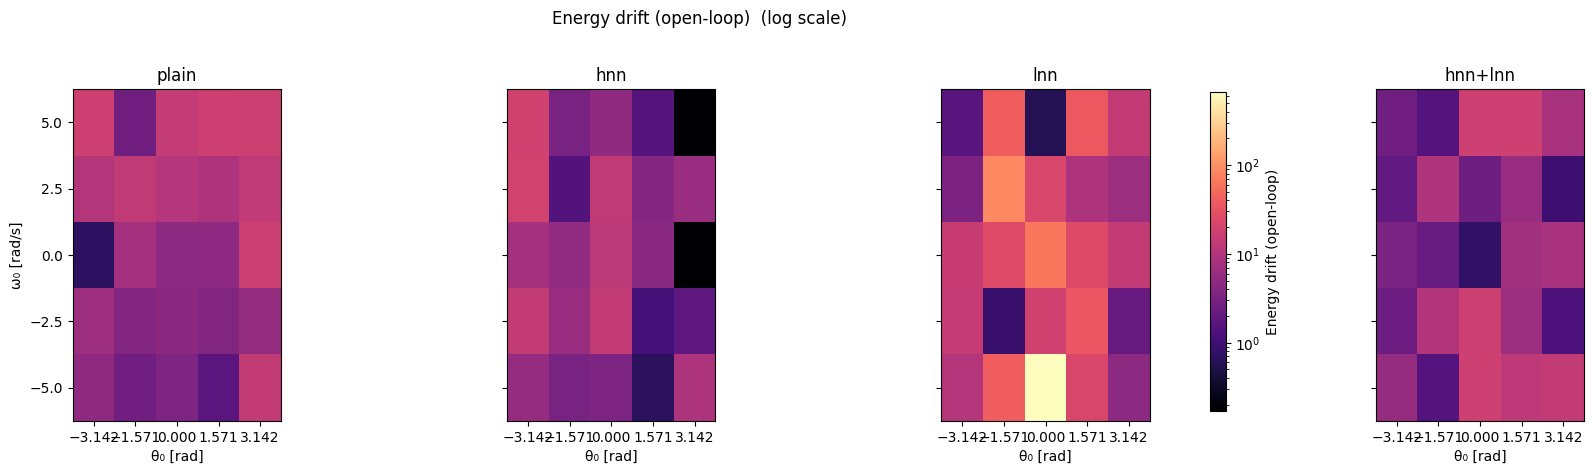

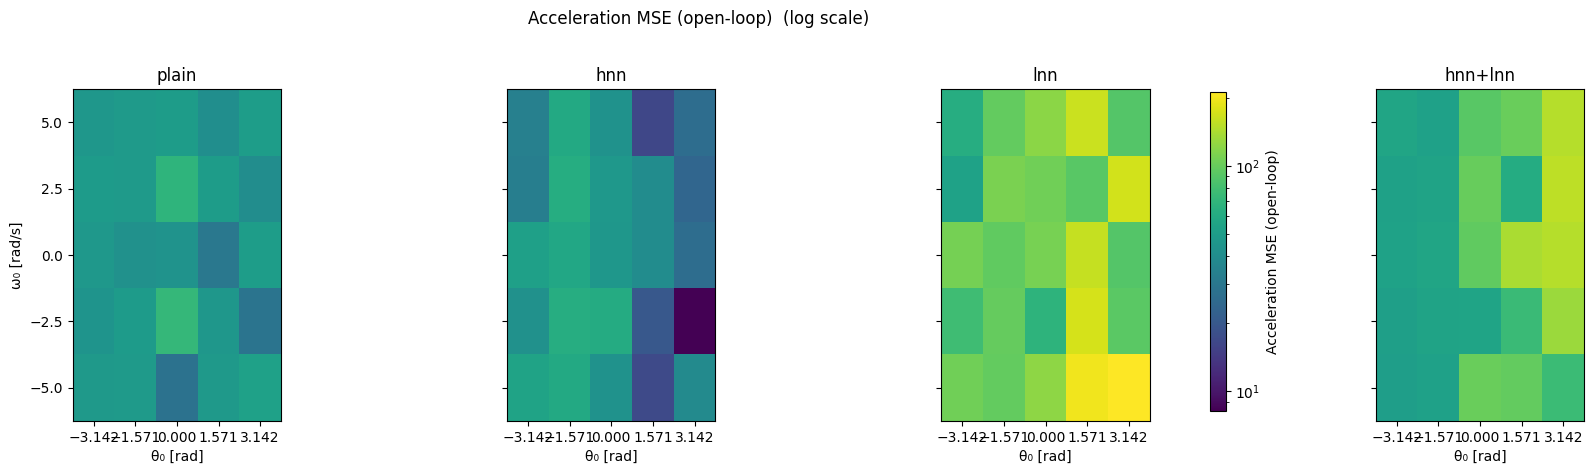

In [24]:
present_modes = [m for m in ["plain","hnn","lnn","hnn+lnn"] if m in results]

# Energy drift (log scale, clip 1..99th percentile across all modes)
plot_metric_row(
    results, present_modes, "E_drift_grid",
    theta_axis=theta_grid, omega_axis=omega_grid,
    title="Energy drift (open-loop)",
    cmap="magma",
    scale="log",
    # clip_percentile=(1, 99),   # optional; remove to use full range
    savepath="heatmaps/row_energy_drift_open_log.png"
)

# Acceleration MSE (log scale)
plot_metric_row(
    results, present_modes, "AccelMSE_grid",
    theta_axis=theta_grid, omega_axis=omega_grid,
    title="Acceleration MSE (open-loop)",
    cmap="viridis",
    scale="log",
    # clip_percentile=(1, 99),
    savepath="heatmaps/row_accel_mse_open_log.png"
)